In [1]:
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d
import math
from scipy import stats
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
import shutil
import os
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Load data and setup

In [2]:
from analysis_functions import *
from plotting_functions import *

### Define parameters

In [3]:
monkey = 'Neville'

In [36]:
# PATHS
datapath = 'E:\\two_boundary\\original_data\\'
figpath = 'E:\\two_boundary\\figures\\'
datapathsave = 'E:\\two_boundary\\data\\'

brain_areas = ['MT', 'MST', 'LIP']

# BRAIN AREAS
#if monkey == 'Neville':
#    brain_areas = ['MT', 'MST', 'LIP']
#else:
#    brain_areas = ['MST', 'LIP']

# BINNING/SMOOTHING PARAMETERS
bins = np.arange(-500, 1600)
sm_std = 40 # gaussian smoothing stdev
bin_size = 100 # msec for binend data

# MIN NUM TRIALS FOR INCLUSION
min_ntrials = 8

# MIN NEURON RATING FOR INCLUSION
min_rating = 2.5

## PSTH

In [81]:
for area in brain_areas[2:]:
    
    trials_per_dir_all = {}
    
    currpath = datapath + monkey + '\\' + area
    os.chdir(currpath)
    
    figpath_good = figpath + 'psth\\' +  monkey + '\\' + area + '\\' + '\\good_neurons\\'
    figpath_bad = figpath + 'psth\\' +  monkey + '\\' + area + '\\bad_neurons\\'
    datapath_good = datapathsave + monkey + '\\' + area + '\\good_neurons\\'
    datapath_bad = datapathsave + monkey + '\\' + area + '\\bad_neurons\\'
    
    make_dirs(figpath_good)
    make_dirs(figpath_bad)
    make_dirs(datapath_good)
    make_dirs(datapath_bad)
    
    filelist = [f for f in glob.glob("*merged_w_ratings.mat")]
    n_files = len(filelist)
    
    # Pre-allocate
    all_ratings = []
    mean_firing_rates = []

    # Loop over files (datasets)
    for file in filelist[2:3]:
        bhv = sio.loadmat(file)['data']['BHV'] # data from monkeylogic bhv files
        neuro = sio.loadmat(file)['data']['NEURO'] # data from neural nex file   

        date = file[8:18] # date of recording session
        
        conditions = bhv[0][0][0][0][3][0] # list of conditions per trial
        errors = bhv[0][0][0][0][5] # list of errors per trial
        code_times = [i[0] for i in neuro[0][0][0][0][2]] # list of code times for each trial
        code_numbers = [i[0] for i in neuro[0][0][0][0][3]] # list of code numbers for each trial

        trial_starts = [i for i, val in enumerate(code_numbers) if val == STRT_TRIAL]

        n_neurons = len(neuro[0][0][0][0][1][0][0]) # list of all neurons from session

        # Loop over neurons
        for i_neuron in range(8):#(n_neurons):
            neuron_name = neuro[0][0][0][0][1][0][0].dtype.names[i_neuron]
            
            if neuron_name[-1] != 'f':
                rating = neuro[0][0][0][0][-1][i_neuron][1][0][0]
                spikes = [i[0] for i in neuro[0][0][0][0][1][0][0][i_neuron]] # array of spike times (relative to session start)    

                [raw_spikes, mean_psth_raw, mean_psth_sm, binned_spikes] = get_psth_ms(spikes, errors, trial_starts, conditions, code_numbers, code_times, bins, sm_std, bin_size)

                if rating >= min_rating:       
                    fname_fig = figpath_good + date + '_' + neuron_name + '.png'
                    fname_data = datapath_good + date + '_' + neuron_name + '.mat'
                    #plot_psth(mean_psth_sm, bins[0:-1], fname_fig, sm_std)
                else:
                    fname_fig = figpath_bad + date + '_' + neuron_name + '.png'
                    fname_data = datapath_bad + date + '_' + neuron_name + '.mat'
                        #plot_psth(mean_psth_sm, bins[0:-1], fname_fig, sm_std)

                    #sp.io.savemat(fname_data,  {'mean_psth_sm': mean_psth_sm, 'mean_psth_raw': mean_psth_raw, 'raw_spikes': raw_spikes,
                    #               'binned_spikes': binned_spikes, 'bins_raw': bins, 'bin_size_binning': bin_size}) 
                


In [83]:
neuron_name

'sig010a'

In [75]:
[np.mean(i[500:800]) for i in mean_psth_sm]

[1.236984995426357,
 0.9013877164593725,
 0.809126066320211,
 0.598556261845632,
 0.4095001428530859,
 0.27761868340899526,
 0.0,
 0.0]

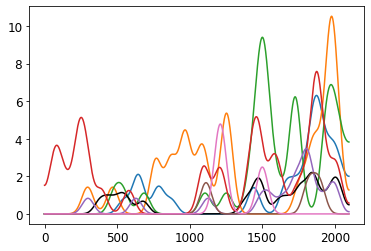

In [76]:
plt.plot(mean_psth_sm[0])
plt.plot(mean_psth_sm[1])
plt.plot(mean_psth_sm[2])
plt.plot(mean_psth_sm[3], 'k')
plt.plot(mean_psth_sm[4])
plt.plot(mean_psth_sm[5])
plt.plot(mean_psth_sm[6])
plt.plot(mean_psth_sm[7])


In [12]:
def get_psth_ms(spikes, errors, trial_starts, conditions, code_numbers, code_times, bins, std = 30, bin_size = 1):

    spikes = np.array(spikes)

    n_conds = 8

    raw_spikes = [[] for i in range(n_conds)]
    psth_binned = [[] for i in range(n_conds)]
    n_trials = len(conditions)

    for i_trial in range(n_trials):

        condition_num = conditions[i_trial]-1

        trial_start_indx = trial_starts[i_trial]
        trial_start_time = code_times[trial_start_indx]

        if errors[i_trial] == 0 and condition_num != PV_COND and code_numbers[trial_start_indx+1] == MS_STIM_ON and code_numbers[trial_start_indx+1] != 1:

            if trial_start_time > spikes[0] and trial_start_time < spikes[-1]:

                if i_trial != n_trials-1:
                    samp_on_indx = [i+trial_start_indx for i, val in enumerate(code_numbers[trial_start_indx:trial_starts[i_trial+1]]) if val == PV_STIM_ON][0]
                else:
                    samp_on_indx = [i+trial_start_indx for i, val in enumerate(code_numbers[trial_start_indx:]) if val == PV_STIM_ON][0]
                samp_on_time = code_times[samp_on_indx]

                t1 = spikes[spikes > samp_on_time-abs(bins[0])]
                t2 =  spikes[spikes < samp_on_time+(bins[-1]+1)]
                spike_times = np.intersect1d(t1, t2) - samp_on_time

                binned = np.histogram(spike_times, bins)[0]
                raw_spikes[condition_num].append(binned)

                psth_binned[condition_num].append(np.convolve(binned, np.ones(bin_size), 'same'))

    mean_psth = np.zeros([n_conds, len(bins)-1])
    for i, curr_spikes in enumerate(raw_spikes):
        mean_psth[i] = np.mean(curr_spikes, 0)*1000

    n_timepoints = np.shape(mean_psth)[1]

    mean_psth_sm = np.zeros([n_conds, n_timepoints])
    for i_cond, curr_spikes in enumerate(mean_psth):
        mean_psth_sm[i_cond] = gaussian_filter1d(mean_psth[i_cond], std)


    return raw_spikes, mean_psth, mean_psth_sm, psth_binned


# Identify task-responsive neurons


In [77]:
for area in brain_areas[0:1]:
    
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\'
    currfigpath = figpath + 'psth\\' + monkey + '\\' + area + '\\good_neurons\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]

    [pvals, fr] = get_task_responsive_cells(filelist, bins, currfigpath)
    

# Quantify single-neuron direction selectivity

# Quantify single-neuron category selectivity (rCTI)

## Setup

In [61]:
DIRS = np.array(DIRS)
BCD_pairs = [[22.5, 157.5], [112.5, 247.5], [202.5, 337.5], [292.5, 67.5], [67.5, 112.5], [157.5, 202.5], [247.5, 292.5], [337.5, 22.5]]
BCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in BCD_pairs]

WCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5], [22.5, 67.5], [202.5, 247.5], [112.5, 157.5], [292.5, 337.5]]
WCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in WCD_pairs]

step_size = 10 # step size for sliding window ROC analysis (in ms)

# Get num neurons per area
n_neurons = {}
for area in brain_areas:
    datadir = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    n_neurons[area] = len(os.listdir(datadir))

## rCTI sliding window

### rCTI for all neurons

In [63]:
rCTI_sliding_window_all = {}
rCTI_mean = {}
rCTI_std = {}

for area in brain_areas: 
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    n_files = len(filelist)

    rCTI_all = [[] for i in range(n_files)]

    for i, file in enumerate(filelist):
        data = sio.loadmat(file)['binned_spikes'][0]
        bins = sio.loadmat(file)['bins_raw'][0][0:-1]      
        
        psth_by_dir = [[] for i in range(N_DIRS)]
        for ii, val in enumerate(np.arange(0, N_CONDS_DMC, 6)):
            psth_by_dir[ii] = np.vstack([iii for iii in data[val:val+6] if len(iii)> 0])

        [WCD_roc_all, WCD_roc] = get_WC_BC_ROC(psth_by_dir, WCD_pairs_indx, step_size)
        [BCD_roc_all, BCD_roc] = get_WC_BC_ROC(psth_by_dir, BCD_pairs_indx, step_size)
    
        rCTI_all[i] = BCD_roc-WCD_roc
    
    rCTI_sliding_window_all[area] = np.squeeze(rCTI_all)
    rCTI_mean[area] = np.mean(rCTI_all, 0)
    rCTI_std[area] = sp.stats.sem(rCTI_all, 0)
    
savepath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
sp.io.savemat(savepath,  {'rCTI_all': rCTI_sliding_window_all, 'rCTI_mean': rCTI_mean, 'rCTI_std': rCTI_std})
    

In [65]:
currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
rCTI_all = sio.loadmat(currdatapath)['rCTI_all']
rCTI_mean = sio.loadmat(currdatapath)['rCTI_mean']
rCTI_std = sio.loadmat(currdatapath)['rCTI_std']

#### Plot rCTI

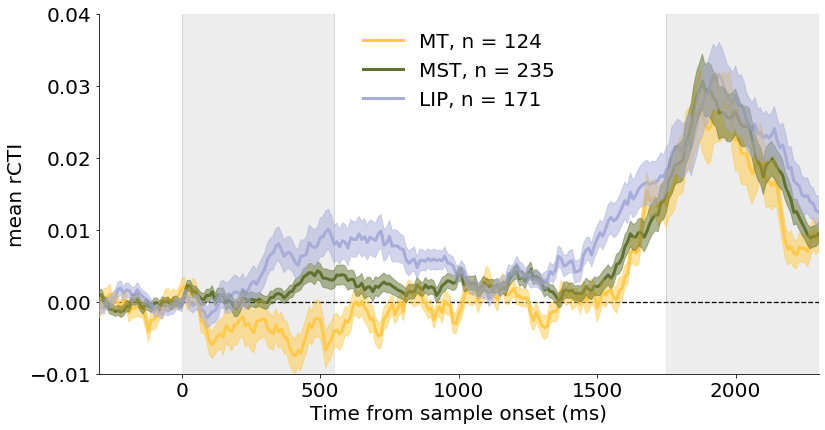

In [67]:
n_timepoints_total = len(data[0][0])
bins_plotting = np.arange(-500, 3050, 10)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)

for i in range(4):
    ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-500, 3000], [0, 0], '--k', lw = 1.3)
plt.ylim([-0.01, 0.04])
plt.xlim([-300, TEST1])

ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    currmean = np.squeeze(rCTI_mean[area][0][0])
    currstd = np.squeeze(rCTI_std[area][0][0])
    
    ax.plot(bins_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(bins_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('mean rCTI', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_sliding_window.' + i
    fig.savefig(savepath, bbox_inches='tight')


### Get proportion cat-tuned and latencies

In [69]:
prop_tuned = {}
latencies_all = {}

bins_rcti = np.arange(-500, 3550-500, 10)
baseline_indx = np.where(bins_rcti < 0)[0]
n_consec = 4

for area in brain_areas:
    
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    os.chdir(currpath)
    filelist = np.array([f for f in glob.glob("*.mat")])

    make_dirs('category_tuned')

    longest_run = np.zeros(n_neurons[area])
    latencies = np.zeros(n_neurons[area])

    for i_neuron in range(n_neurons[area]):                 
        mean_baseline = np.mean(rCTI_all[area][0][0][i_neuron][baseline_indx])
        std_baseline = np.std(rCTI_all[area][0][0][i_neuron][baseline_indx])

        thresh_above = mean_baseline + std_baseline*4
        thresh_below = mean_baseline - std_baseline*4

        above_thresh_indx = [1 if i > thresh_above else 0 for i in rCTI_all[area][0][0][i_neuron, baseline_indx[-1]:TEST1+500]]
        [run, lat] = max_consecutive_vals(above_thresh_indx, 1, n_consec)

        longest_run[i_neuron] = run

        if lat:
            latencies[i_neuron] = bins_rcti[lat + baseline_indx[-1]] 
        else:
            latencies[i_neuron] = np.nan

    prop_tuned[area] = (len(np.where(longest_run >= n_consec)[0])/n_neurons[area])

    latencies_cleaned = [i for i in latencies if not np.isnan(i)]
    latencies_all[area] = latencies_cleaned
    
    sig_indx = np.where(longest_run >= n_consec)[0]

    for file in filelist[np.where(longest_run >= n_consec)[0]]:
        destination_mat = 'category_tuned\\' + file
        figfile = currpath + file
        shutil.copy(file, destination_mat)    
    

#### Plot proportion category-tuned

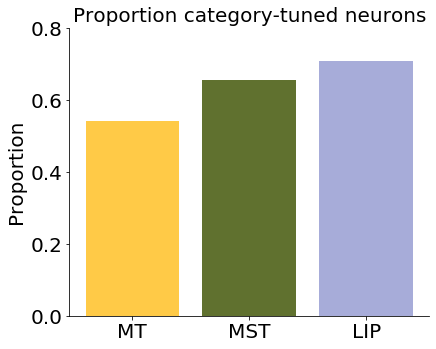

In [71]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

ax.bar(brain_areas, [prop_tuned['MT'], prop_tuned['MST'], prop_tuned['LIP']], color = [plot_colors['MT'], plot_colors['MST'], plot_colors['LIP']])
#ax.bar(brain_areas, [prop_tuned['MST'], prop_tuned['LIP']], color = [plot_colors['MST'], plot_colors['LIP']])
ax.set_ylabel('Proportion', fontsize = 20)

ax.set_title('Proportion category-tuned neurons', fontsize = 20)
plt.ylim(0, 0.8)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

plt.show()

for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_prop_tuned.' + i
    fig.savefig(savepath, bbox_inches='tight')

#### Calculate and plot ECDF of latency

In [29]:
x_vals = [[] for i in range(3)]
y_vals = [[] for i in range(3)]

latencies_array = [[] for i in range(3)]

for i, area in enumerate(brain_areas):
    [x, y] = ecdf(latencies_all[area])
    x_vals[i] = x
    y_vals[i] = y
    
    latencies_array[i] = np.array(latencies_all[area])

In [30]:
'''
nSig_sample = np.zeros(3)
nSig_delay = np.zeros(3)
nSig_test = np.zeros(3)

for i in range(3):
    nSig_sample[i] = len(np.intersect1d(np.where(latencies_array[i] >= 0)[0], np.where(latencies_array[i] <= sample)[0]))
    nSig_delay[i] = len(np.intersect1d(np.where(latencies_array[i] >= sample)[0], np.where(latencies_array[i] <= delay1)[0]))
    nSig_test[i] = len(np.intersect1d(np.where(latencies_array[i] >= delay1)[0], np.where(latencies_array[i] <= test1)[0]))
'''

'\nnSig_sample = np.zeros(3)\nnSig_delay = np.zeros(3)\nnSig_test = np.zeros(3)\n\nfor i in range(3):\n    nSig_sample[i] = len(np.intersect1d(np.where(latencies_array[i] >= 0)[0], np.where(latencies_array[i] <= sample)[0]))\n    nSig_delay[i] = len(np.intersect1d(np.where(latencies_array[i] >= sample)[0], np.where(latencies_array[i] <= delay1)[0]))\n    nSig_test[i] = len(np.intersect1d(np.where(latencies_array[i] >= delay1)[0], np.where(latencies_array[i] <= test1)[0]))\n'

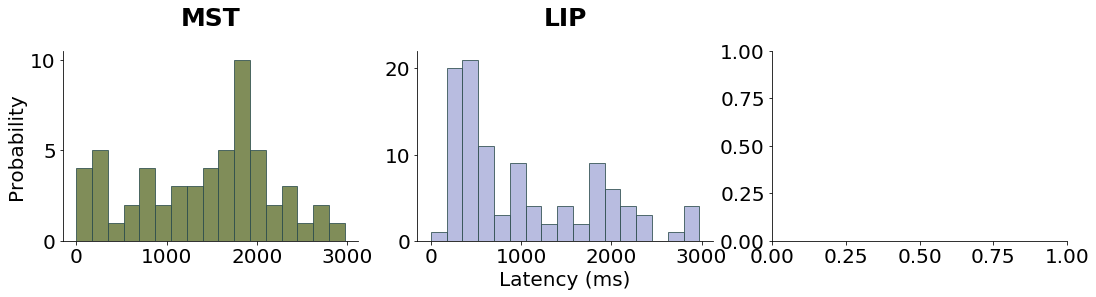

In [31]:
fig, ax =  plt.subplots(1, 3, figsize=(18, 3.5))

for i, area in enumerate(brain_areas):
    ax[i].hist(latencies_all[area], bins = np.arange(0, 3000, 175), edgecolor = 'darkslategrey', alpha = 0.8, density = False, facecolor = plot_colors[area], label = area)
    ax[i].set_title(brain_areas[i], fontsize = 25, y = 1.1, fontweight = 'bold')

    
ax[0].set_ylabel('Probability', fontsize = 20)
ax[1].set_xlabel('Latency (ms)', fontsize = 20)

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)
    ax[i].tick_params(labelsize=20)

plt.show()
for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_latency.' + i
    fig.savefig(savepath, bbox_inches='tight')


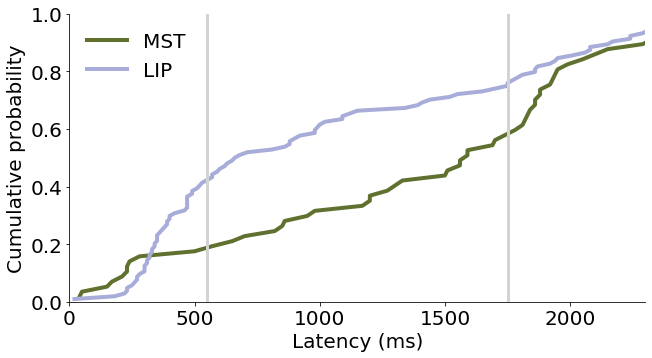

In [32]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1,1,1,1])

for i, area in enumerate(brain_areas):
    ax.plot(x_vals[i], y_vals[i], color = plot_colors[area], lw = 4, label = area)


for i in range(2):
    ax.plot([trial_epochs[i], trial_epochs[i]], [0, 1], 'lightgrey', lw = 3)


ax.set_xlabel('Latency (ms)', fontsize = 20)
ax.set_ylabel('Cumulative probability', fontsize = 20)
plt.xlim(-1, test1)
plt.ylim(0, 1)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

ax.legend(frameon = False, fontsize = 20)

plt.show()
for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_latency_ecdf.' + i
    fig.savefig(savepath, bbox_inches='tight')


### rCTI category-tuned only

In [19]:
rCTI_sliding_window_all = {}
rCTI_mean = {}
rCTI_std = {}

for area in brain_areas: 
    dirs = np.array(dirs)

    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\category_tuned\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    n_files = len(filelist)

    rCTI_all = [[] for i in range(n_files)]

    for i, file in enumerate(filelist):
        data = sio.loadmat(file)['binned_spikes'][0]
        bins = sio.loadmat(file)['bins_raw'][0][0:-1]      
        
        psth_by_dir = [[] for i in range(12)]
        for ii, val in enumerate(np.arange(0, 72, 6)):
            psth_by_dir[ii] = np.vstack([iii for iii in data[val:val+6] if len(iii)> 0])

        [WCD_roc_all, WCD_roc] = get_WC_BC_ROC(psth_by_dir, WCD_pairs_indx, step_size)
        [BCD_roc_all, BCD_roc] = get_WC_BC_ROC(psth_by_dir, BCD_pairs_indx, step_size)
    
        rCTI_all[i] = BCD_roc-WCD_roc
    
    rCTI_sliding_window_all[area] = np.squeeze(rCTI_all)
    rCTI_mean[area] = np.mean(rCTI_all, 0)
    rCTI_std[area] = sp.stats.sem(rCTI_all, 0)
    
savepath = figpath + 'rCTI\\' + monkey + '_rCTI_category_tuned.mat'
sp.io.savemat(savepath,  {'rCTI_all': rCTI_sliding_window_all, 'rCTI_mean': rCTI_mean, 'rCTI_std': rCTI_std})
    

In [20]:
currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI_category_tuned.mat'
rCTI_all_cat = sio.loadmat(currdatapath)['rCTI_all']
rCTI_mean_cat = sio.loadmat(currdatapath)['rCTI_mean']
rCTI_std_cat = sio.loadmat(currdatapath)['rCTI_std']

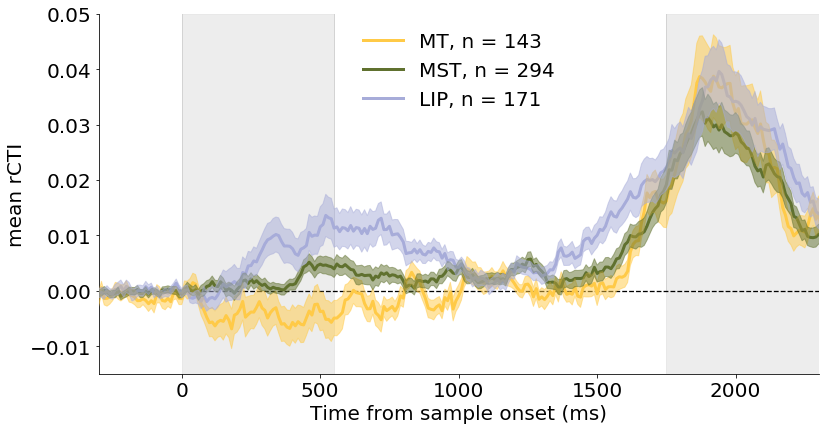

In [21]:
n_timepoints_total = len(data[0][0])
bins_plotting = np.arange(-500, 3050, 10)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)

for i in range(4):
    ax.plot([trial_epochs[i], trial_epochs[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-500, 3000], [0, 0], '--k', lw = 1.3)
plt.ylim([-0.015, 0.05])
plt.xlim([-300, test1])

ax.axvspan(0, sample, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(delay1, test1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = np.squeeze(rCTI_mean_cat[area][0][0])
    currstd = np.squeeze(rCTI_std_cat[area][0][0])
    
    ax.plot(bins_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(bins_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('mean rCTI', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'rCTI\\' + monkey + '_rCTI_sliding_window_cat_tuned.' + i
    fig.savefig(savepath, bbox_inches='tight')


## rCTI per epoch

In [ ]:
area = 'LIP'

dirs = np.array(dirs)

currpath = datapath + area + '\\good_neurons\\task_responsive\\'
currfigpath = figpath + 'psth\\' + area + '\\good_neurons\\'

os.chdir(currpath)
filelist = [f for f in glob.glob("*.mat")]
n_files = len(filelist)

#rCTI_all = [[] for i in range(n_files)]

for file in filelist:
    data = sio.loadmat(file)
    data = data['raw_spikes']
    data = np.array(np.squeeze(all_spikes))


    [WCD_roc_all, WCD_roc] = get_WC_BC_ROC(data, WCD_pairs_indx)
    [BCD_roc_all, BCD_roc] = get_WC_BC_ROC(data, BCD_pairs_indx)

    rCTI_all[i] = BCD_roc-WCD_roc
    
rCTI_mean = np.mean(rCTI_all, 0)
rCTI_sem = sp.stats.sem(rCTI_all, 0)

savepath = figpath + 'rCTI\\' + area + '_rCTI.mat'
sp.io.savemat(savepath,  {'rCTI_all': rCTI_all, 'rCTI_mean': rCTI_mean, 'rCTI_sem': rCTI_sem}) 


In [ ]:
def get_WC_BC_ROC_epoch(data, pairs_indx, trial_epochs):
    
    indx_baseline = epoch_inds(bins, -500, 0)
    indx_samp = epoch_inds(bins, 0, trial_epochs[0])
    indx_delay1 = epoch_inds(bins, trial_epochs[0], trial_epochs[1]-600)
    indx_delay2 = epoch_inds(bins, trial_epochs[1]-600, trial_epochs[1])
    indx_test1 = epoch_inds(bins, trial_epochs[1], trial_epochs[2])

    n_pairs = len(pairs_indx)
           
    [mean_baseline, all_baseline] = get_epoch_means(data, indx_baseline)
    [mean_samp, all_samp] = get_epoch_means(data, indx_samp)
    [mean_delay1, all_delay1] = get_epoch_means(data, indx_delay1)
    [mean_delay2, all_delay2] = get_epoch_means(data, indx_delay2)
    [mean_test1, all_test1] = get_epoch_means(data, indx_test1)    


    roc_all = np.zeros([n_pairs, n_timepoints])

    for i_pair in range(n_pairs):
        dir1 = data[pairs_indx[i_pair][0]]
        dir2 = data[pairs_indx[i_pair][1]]

        for i_timepoint in range(n_timepoints):
            y_true = np.hstack([np.zeros(np.size(dir1, 0)), np.ones(np.size(dir2, 0))])
            y_data = np.hstack([dir1[:, i_timepoint], dir2[:, i_timepoint]])    

            curr_roc = abs(roc_auc_score(y_true, y_data) - 0.5)
            roc_all[i_pair, i_timepoint] = curr_roc
            
    mean_roc = np.mean(roc_all, 0)

    return roc_all, mean_roc
        

# Boundary vs center bias

In [528]:
dirs = [247.5, 225, 202.5, 67.5, 45, 22.5, 157.5, 135, 112.5, 337.5, 315, 292.5]

center_dirs = [i for i, val in enumerate(dirs) if isinstance(val, int)]
vert_dirs = [3, 8, 6, 9]
horz_dirs = [0, 5, 2, 11]

In [799]:
area = 'MST'

dirs = np.array(dirs)

currpath = datapath + area + '\\good_neurons\\by_dir\\task_responsive\\'
#currfigpath = figpath + 'psth\\' + area + '\\good_neurons\\'

sigs = [0, 0, 0]

os.chdir(currpath)
filelist = [f for f in glob.glob("*.mat")]
n_files = len(filelist)

all_center = []
all_vert = []
all_horz = []

for file in filelist:
    data = sio.loadmat(file)
    spikes = data['binned_spikes']
    spikes = np.array(np.squeeze(spikes))
    
    bins = data['bins_raw']
    indx = np.intersect1d(np.where(bins > 80)[1], np.where(bins < 280)[1])

    center = np.vstack(spikes[center_dirs])
    vert = np.vstack(spikes[vert_dirs])
    horz = np.vstack(spikes[horz_dirs])
    
    center_mean = np.mean(center[:, indx], 1)
    vert_mean = np.mean(vert[:, indx], 1)    
    horz_mean = np.mean(horz[:, indx], 1)

    [f, pval] = stats.f_oneway(center_mean, vert_mean, horz_mean)
    
    if pval <= 0.05:
        sigindx = np.argmax([np.mean(center_mean), np.mean(vert_mean), np.mean(horz_mean)])
        sigs[sigindx] += 1
        #print(file)
    
    all_center.append(np.mean(center_mean))
    all_vert.append(np.mean(vert_mean))
    all_horz.append(np.mean(horz_mean))
    


In [800]:
sigs

[6, 17, 12]

(array([ 7., 24., 56., 62., 55., 31., 10.,  9.,  3.,  2.]),
 array([ 0.44221106,  1.73115578,  3.0201005 ,  4.30904523,  5.59798995,
         6.88693467,  8.1758794 ,  9.46482412, 10.75376884, 12.04271357,
        13.33165829]),
 <a list of 10 Patch objects>)

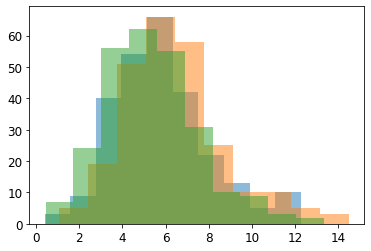

In [568]:
plt.hist(center_mean, alpha = 0.5)
plt.hist(vert_mean, alpha = 0.5)
plt.hist(horz_mean, alpha = 0.5)

In [555]:
sum(sigs)/n_files*100

10.429447852760736

# Early vs late sample selectivity

In [789]:
area = 'MT'
indx = np.intersect1d(np.where(bins > 80)[1], np.where(bins < 280)[1])
indx2 = np.intersect1d(np.where(bins > 380)[1], np.where(bins < 530)[1])

#dirs = np.array(dirs)

currpath = datapath + area + '\\good_neurons\\by_dir\\task_responsive\\'
#currfigpath = figpath + 'psth\\' + area + '\\good_neurons\\'

sigs = [0, 0, 0]

os.chdir(currpath)
filelist = [f for f in glob.glob("*.mat")]
n_files = len(filelist)

all_center = []
all_vert = []
all_horz = []
for file in filelist[0:2]:
    data = sio.loadmat(file)
    spikes = data['mean_psth_raw']
    spikes = np.array(np.squeeze(spikes))
    
    early_tuning = np.mean(spikes[:, indx], 1)
    late_tuning =  np.mean(spikes[:, indx2], 1)
    
    ord_ind = np.argsort(dirs)
    early_tuning = [early_tuning[i] for i in ord_ind]
    late_tuning = [late_tuning[i] for i in ord_ind]
    ord_dirs = [dirs[i] for i in ord_ind]
    
    ord_center = [1, 4, 7, 10]
    order_vert = [0, 11, 5, 6]
    order_horz = [2, 3, 8, 9]

    early_tuning_norm = (early_tuning- min(early_tuning))/(max(early_tuning) - min(early_tuning))
    late_tuning_norm = (late_tuning- min(late_tuning))/(max(late_tuning) - min(late_tuning))
    
    

In [790]:
file

'20191004_1_SPK03a.mat'

[[<matplotlib.lines.Line2D at 0x1934abb9a20>],

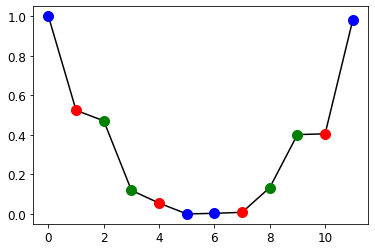

In [791]:
plt.plot(early_tuning_norm, 'k')
[plt.plot(i, v, '.b', MarkerSize = 20) for i, v in enumerate(early_tuning_norm) if i in order_vert]
[plt.plot(i, v, '.r', MarkerSize = 20) for i, v in enumerate(early_tuning_norm) if i in ord_center]
[plt.plot(i, v, '.g', MarkerSize = 20) for i, v in enumerate(early_tuning_norm) if i in order_horz]


[[<matplotlib.lines.Line2D at 0x1934ac34908>],

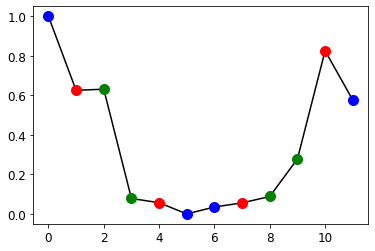

In [792]:
plt.plot(late_tuning_norm, 'k')
[plt.plot(i, v, '.b', MarkerSize = 20) for i, v in enumerate(late_tuning_norm) if i in order_vert]
[plt.plot(i, v, '.r', MarkerSize = 20) for i, v in enumerate(late_tuning_norm) if i in ord_center]
[plt.plot(i, v, '.g', MarkerSize = 20) for i, v in enumerate(late_tuning_norm) if i in order_horz]

#plt.plot(late_tuning_norm, 'grey')

# Decoder analysis

### Setup

In [ ]:
cat_svm_perf = {}
dir_svm_perf = {}

window = windows[0]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])
timepoints = np.arange(0, len(window))

for area in brain_areas:
    if exclude_stim1:  
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
    else:
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]  
    
    n_neurons_decoder = len(filelist)

    spikes_all = {}
    spikes_all['PV'], spikes_all['DMC'] = [], []
    cat_perf_all = {}
    dir_perf_all = {}

    for file in filelist:
        data = sio.loadmat(file)
        spikes_all['PV'].append(data['spikes_binned_pv'].flatten())
        spikes_all['DMC'].append(data['spikes_binned_dmc'].flatten())
        
    for task in tasks:
        cat_perf_all[task] = category_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_cat)    
        dir_perf_all[task] = direction_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_dir)    
    
    cat_svm_perf[area] = cat_perf_all
    dir_svm_perf[area] = dir_perf_all

In [12]:
monkey = 'Neville'

### Decoder analysis parameters

In [41]:
# Num iterations
n_iter = 200

# Num trials
n_trials_cat = 20 # per dir, so per cat = 60
n_trials_dir = 12 # per dir

# Equal number of neurons per area
count_matched = True

In [42]:
# Get number of neurons per area
n_neurons = {}
for area in brain_areas:
    datadir = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    n_neurons[area] = len(os.listdir(datadir))


### Category decoder

In [43]:
cat_decoder_mean_all = {}
dir_decoder_mean_all = {}

for i_area, area in enumerate(brain_areas):                   
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    
    if count_matched:
        n_neurons_decoder = min([n_neurons[area] for area in brain_areas])     
        savepath_cat = figpath + 'category_decoding\\' +  monkey + '_cat_decoder_count_matched.mat'
        savepath_dir = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_matched.mat'
    else:
        n_neurons_decoder = n_neurons[area]    
        savepath_cat = figpath + 'category_decoding\\' +  monkey + '_cat_decoder_count_unmatched.mat'   
        savepath_dir = figpath + 'direction_decoding\\' +  monkey + 'dir_decoder_count_matched.mat'
        
    decoder_all, decoder_mean, decoder_std = run_decoder_dmc(filelist, bins, 'cat', n_trials_cat, n_neurons_decoder, n_neurons[area]) 
    cat_decoder_mean_all[area] = {'decoder_mean': decoder_mean, 'decoder_std': decoder_std, 'decoder_all': decoder_all}
        
    decoder_all, decoder_mean, decoder_std = run_decoder_dmc(filelist, bins, 'dir', n_trials_dir, n_neurons_decoder, n_neurons[area]) 
    dir_decoder_mean_all[area] = {'decoder_mean': decoder_mean, 'decoder_std': decoder_std, 'decoder_all': decoder_all}
    
sp.io.savemat(savepath_cat, {'cat_decoder_mean_all': cat_decoder_mean_all}) 
sp.io.savemat(savepath_dir, {'dir_decoder_mean_all': dir_decoder_mean_all})    

In [16]:
def run_decoder_dmc(filelist, bins, decoder_type, n_trials, n_neurons_decoder, n_neurons_total):
    
    timepoints = np.arange(0, len(bins))
    
    # Pre-allocate
    decoder_all, decoder_mean, decoder_std = {}, {}, {}
    spikes_all = []
    
    for file in filelist:
        data = sio.loadmat(file)
        data_by_cond = data['binned_spikes'].flatten()
        data_by_dir = org_data_by_dir(data_by_cond)

        spikes_all.append(data_by_dir)

    if decoder_type == 'cat':
        perf = category_decoder(spikes_all, n_iter, timepoints, n_neurons_decoder, n_neurons_total, n_trials) 
    elif decoder_type == 'dir':
        perf = direction_decoder(spikes_all, n_iter, timepoints, n_neurons_decoder, n_neurons_total, n_trials)

    perf_mean = np.mean(perf, 0)
    perf_std = np.std(perf, 0)

    decoder_mean[area] = perf_mean
    decoder_std[area] = perf_std
    decoder_all[area] = perf

    return perf, perf_mean, perf_std

### Plotting

In [50]:
currdatapath = figpath + 'category_decoding\\' +  monkey + '_cat_decoder_count_matched.mat'
cat_decoder_mean_all = sio.loadmat(currdatapath)['cat_decoder_mean_all'][0][0].flatten()
#cat_decoder_mean_all = sio.loadmat(currdatapath)['perf_std'] 

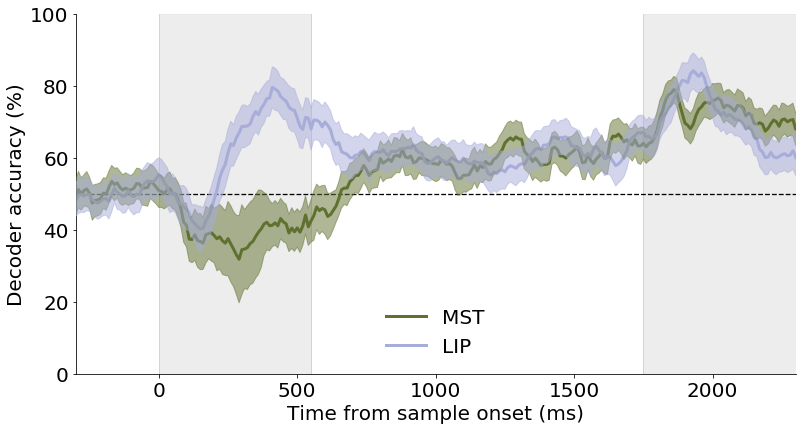

In [51]:
tp_plotting = np.arange(-500, 3050, 10)
       
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])
        
ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [50, 50], '--k', lw = 1.3)
plt.ylim([0, 100])
plt.xlim([-300, TEST1])
#plt.xlim([2800, test2])

ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = cat_decoder_mean_all[area][0][0]['decoder_mean'][0][0]
    currstd = cat_decoder_mean_all[area][0][0]['decoder_std'][0][0]
    
    ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = area)
    #ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(tp_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'category_decoding\\' + monkey + '_cat_decoder_count_matched.' + i
    #fig.savefig(savepath, bbox_inches='tight')


## Direction decoding

In [19]:
monkey = 'Stanton'

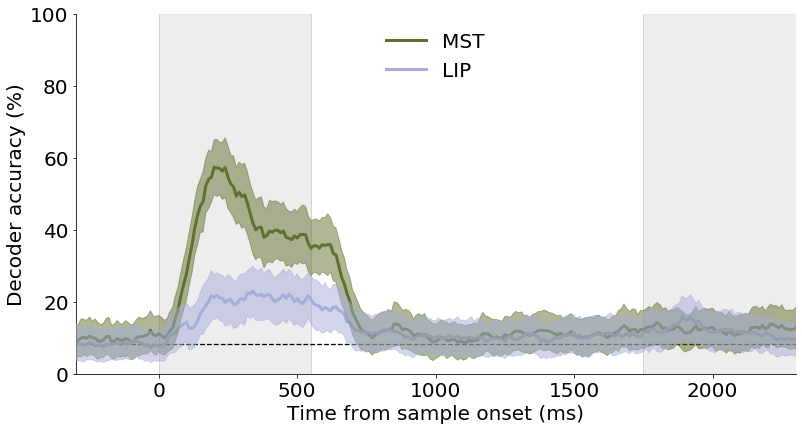

In [52]:
currdatapath = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_matched.mat'
cat_decoder_mean_all = sio.loadmat(currdatapath)['dir_decoder_mean_all'][0][0].flatten()

tp_plotting = np.arange(-500, 3050, 10)
       
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])
        
ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([TRIAL_EPOCHS[i], TRIAL_EPOCHS[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [1/12*100, 1/12*100], '--k', lw = 1.3)
plt.ylim([0, 100])
plt.xlim([-300, TEST1])
#plt.xlim([2800, test2])

ax.axvspan(0, SAMPLE_STIM, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(DELAY1, TEST1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = cat_decoder_mean_all[area][0][0]['decoder_mean'][0][0]
    currstd = cat_decoder_mean_all[area][0][0]['decoder_std'][0][0]
    
    ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = area)
    #ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(tp_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'direction_decoding\\' + monkey + '_dir_decoder_count_matched.' + i
    #fig.savefig(savepath, bbox_inches='tight')


In [72]:
currdatapath = figpath + 'direction_decoding\\' +  monkey + '_dir_decoder_count_matched.mat'
perf_mean_dir = sio.loadmat(currdatapath)['perf_mean']
perf_std_dir = sio.loadmat(currdatapath)['perf_std']

### Plotting

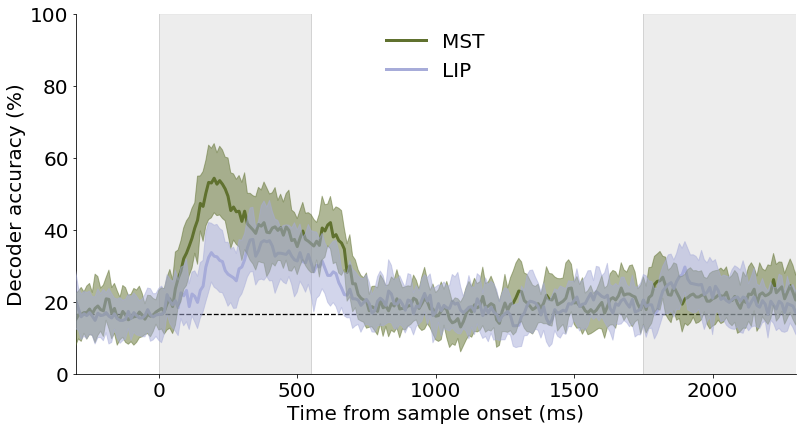

In [73]:
tp_plotting = np.arange(-500, 3050, 10)
       
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])
        
ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)
for i in range(4):
    ax.plot([trial_epochs[i], trial_epochs[i]], [0, 100], 'lightgrey', lw = 1)

ax.plot([-400, 3000], [1/6*100, 1/6*100], '--k', lw = 1.3)
plt.ylim([0, 100])
plt.xlim([-300, test1])
#plt.xlim([2800, test2])

ax.axvspan(0, sample, alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(delay1, test1, alpha = 0.4, color = 'lightgrey', zorder=2)

for area in brain_areas:
    
    currmean = np.squeeze(perf_mean_dir[area][0][0])
    currstd = np.squeeze(perf_std_dir[area][0][0])
    
    ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = area)
    #ax.plot(tp_plotting, currmean, color = plot_colors[area],  lw = 3, label = "{0}, n = {1}".format(area, n_neurons[area]))
    ax.fill_between(tp_plotting, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)
    
    
ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = figpath + 'direction_decoding\\' + monkey + '_dir_decoder_unmatched_count.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [65]:
tp_plotting = np.arange(-500, 3050, 10)
       
fig, ax =  plt.subplots(1, 3, figsize=(20, 4.5))

for i in range(3):
    ax[i].plot([0, 0], [0, 100], 'lightgrey', lw = 1)
    for ii in range(4):
        ax[i].plot([trial_epochs[ii], trial_epochs[ii]], [0, 100], 'lightgrey', lw = 1)
    ax[i].plot([-400, 3000], [1/6*100, 1/6*100], '--k', lw = 1.3)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].axvspan(0, sample, alpha = 0.4, color = 'lightgrey', zorder=1)
    ax[i].axvspan(delay1, test1, alpha = 0.4, color = 'lightgrey', zorder=2)
    ax[i].set_ylim(10, 60)
    ax[i].set_xlim(-300, test1)
    ax[i].set_title(brain_areas[i], fontsize = 20)
    
ax[0].plot(tp_plotting, perf_cat_MT, color = color_MT, linestyle = '--', lw = 2.5)
ax[0].plot(tp_plotting, perf_cat_MT_all, color = color_MT, lw = 2.5)
ax[0].set_ylabel('Performance (%)', fontsize = 20)

ax[1].plot(tp_plotting, perf_cat_MST, color = color_MST, linestyle = '--', lw = 2.5)
ax[1].plot(tp_plotting, perf_cat_MST_all, color = color_MST, lw = 2.5, zorder = 10)
ax[1].plot(tp_plotting, perf_cat_MST, color = 'k', linestyle = '--', lw = 2.5, label = 'Only category-tuned neurons', zorder=1)
ax[1].plot(tp_plotting, perf_cat_MST_all, color = 'k', lw = 2.5, label = 'All neurons', zorder=1)
ax[1].set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax[1].legend(frameon = False, fontsize = 15)

ax[2].plot(tp_plotting, perf_cat_LIP, color = color_LIP, linestyle = '--', lw = 2.5)
ax[2].plot(tp_plotting, perf_cat_LIP_all, color = color_LIP, lw = 2.5)

#savepath = figpath + 'direction_decoding\\dir_decoder_cat_tuned_comparison.png'
#fig.savefig(savepath, bbox_inches='tight')


# PCA

In [86]:
monkey = 'Neville'

In [200]:
timepoints = np.arange(np.where(bins == -100)[0][0], np.where(bins == SAMPLE_STIM)[0][0])

for area in brain_areas[2:]:
    
    if monkey != 'both':
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]

    else:
        currpath1 = datapathsave + 'Neville' + '\\' + area + '\\good_neurons\\task_responsive\\'   
        currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\good_neurons\\task_responsive\\'
      
        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = []

    for file in filelist:
        data = sio.loadmat(file)
        data_by_cond = data['binned_spikes'].flatten()*10
        data_by_dir = org_data_by_dir(data_by_cond)
        stacked = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints], 0), 30) for i in data_by_dir])       
        spikes_all.append(stacked.T)
        
    #for task in tasks:
        #cat_perf_all[task] = category_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_cat)    
        #dir_perf_all[task] = direction_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_dir)    
    


In [201]:
from sklearn.decomposition import PCA

all_stacked = np.array(spikes_all).T    

pca = PCA(n_components = len(filelist))
pca.fit(all_stacked)

projection = pca.transform(all_stacked)

n_timepoints = len(timepoints)

pca_indices = {}

for i_dir in range(N_DIRS):
    startindx = 0+(n_timepoints*i_dir)
    pca_indices[i_dir] = [startindx, startindx+n_timepoints]


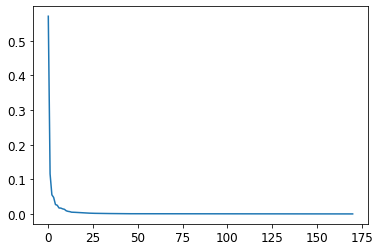

In [202]:
%matplotlib inline
plt.plot(range(0, len(filelist)), pca.explained_variance_ratio_)

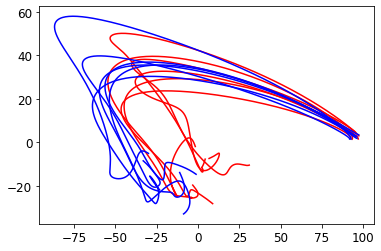

In [203]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'r')
    
for i_dir in range(6, 12):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'b')



<IPython.core.display.Javascript object>


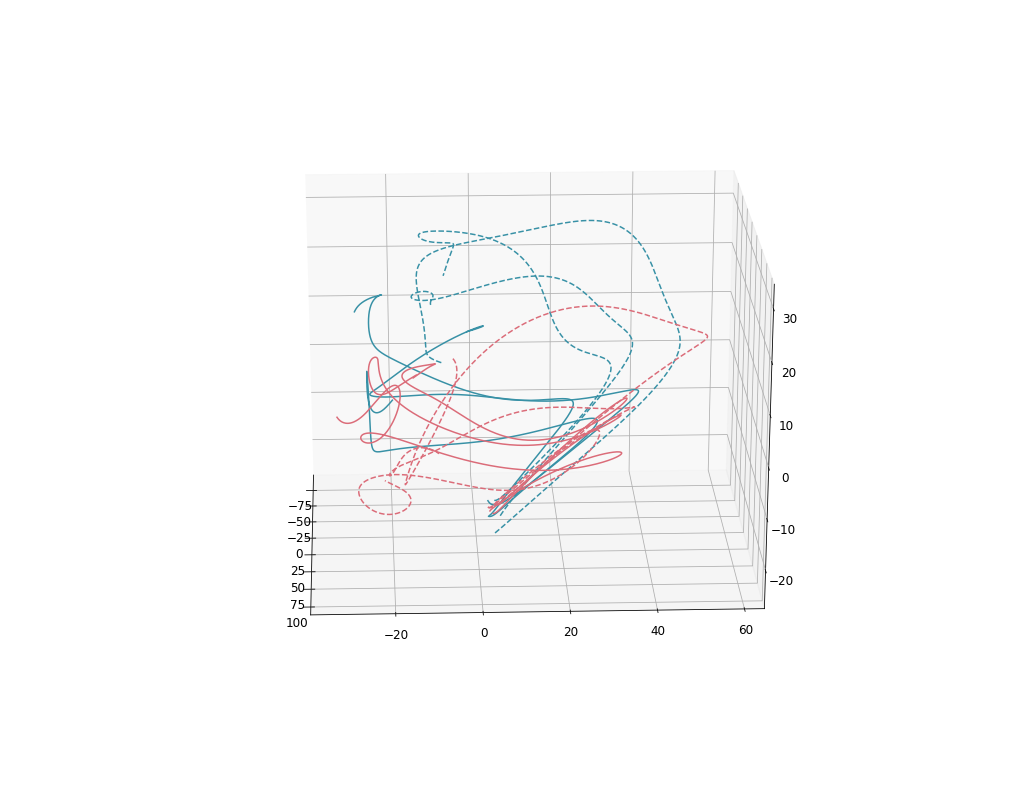

In [207]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(3):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category1'])

for i_dir in range(3, 6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category1'])
        
for i_dir in range(6, 9):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category2'])

for i_dir in range(9, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category2'])



<IPython.core.display.Javascript object>


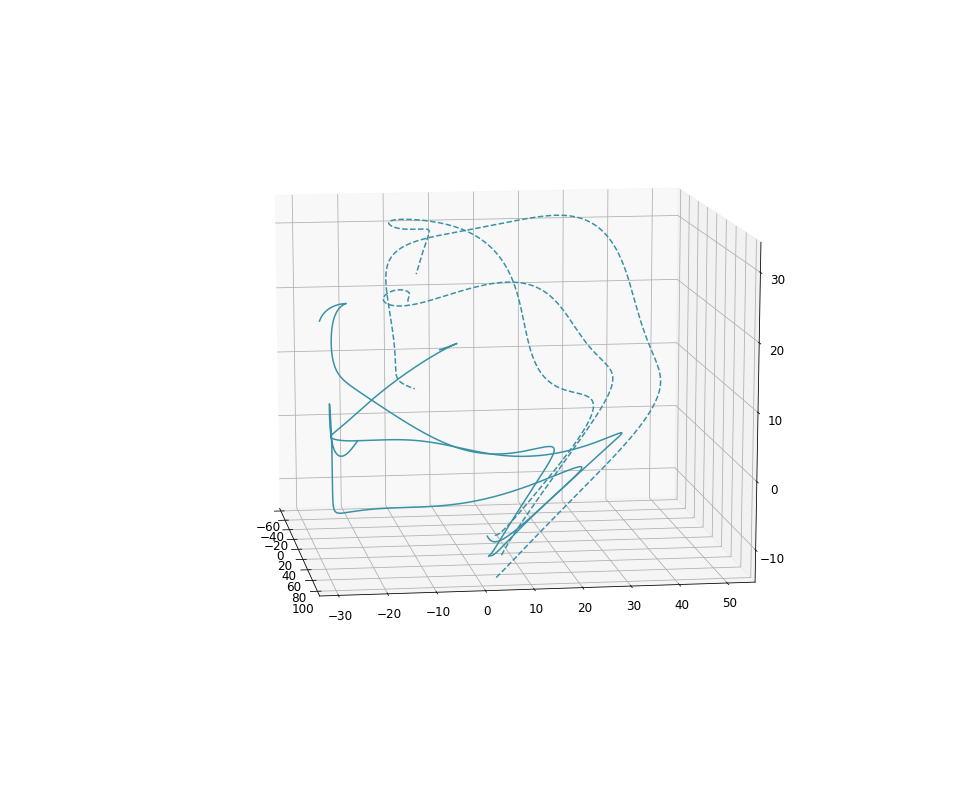

In [205]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(3):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category1'])

for i_dir in range(3, 6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category1'])
        

<IPython.core.display.Javascript object>


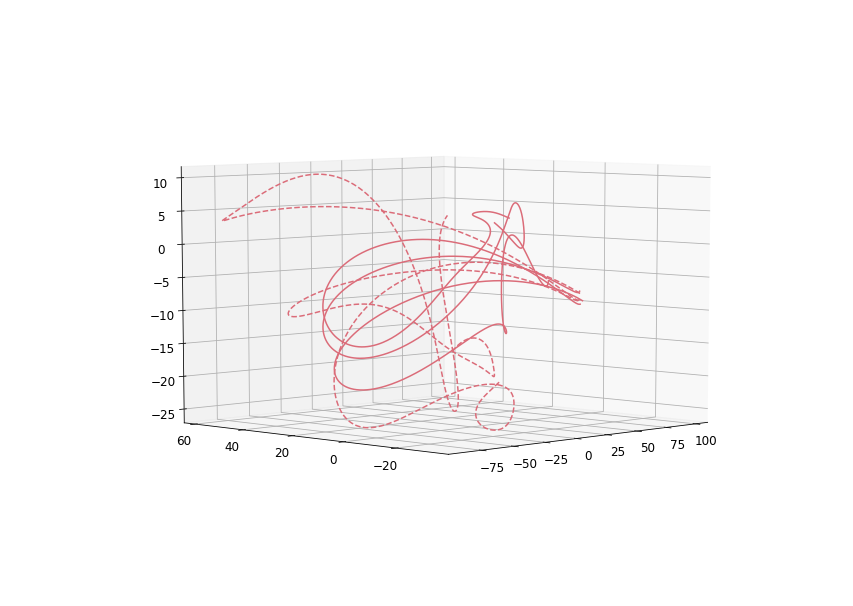

In [206]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')


for i_dir in range(6, 9):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category2'])

for i_dir in range(9, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category2'])

